Imports

In [2]:
#code written by Joe Mandell, begun march 6 2024
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import KFold

import hashlib
import re
import os

train = pd.read_csv('SteelPlate/train.csv')
test = pd.read_csv('SteelPlate/test.csv')

train.head(3)
#possible resource for visualization
#https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57
#https://seaborn.pydata.org/tutorial/function_overview.html
#implementation of XGBoost technique
#https://www.kaggle.com/code/akhiljethwa/playground-s4e1-eda-modeling-xgboost
#https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0


### EDA (exploratory data analysis)
- we have no null values
#### categorical values
- Steel type seems to be the only categorical variable - steel types are encoded as true/false for A300 and A400
- definitely impacts certain features (bumps), doesn't really change dirtiness
- the id values don't seem to correlate very strongly with anything, likely safe to drop these
#### continuous values
- pretty much everything else is continuous
- diverse set of distributions - unimodal, bimodal, lots of right-tailed.
- however, common pattern in many of the bimodal distributions - a huge spike in non-defective observations at one specific value (probably the spec)
- Models used to predict should try to be sensitive to these huge spikes, since they seem strongly predictive of properly-made plates.



id


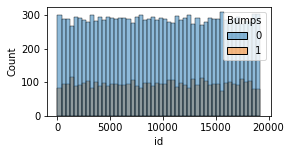

X_Minimum


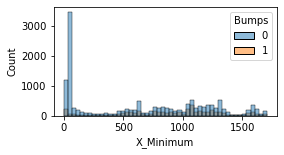

X_Maximum


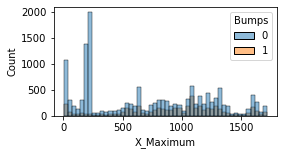

Y_Minimum


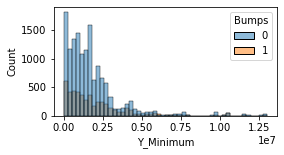

Y_Maximum


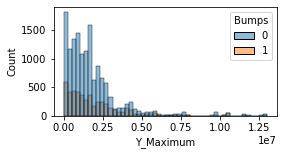

Pixels_Areas


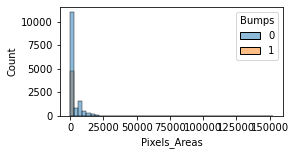

X_Perimeter


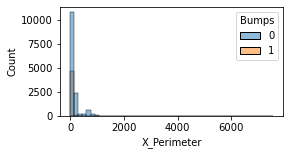

Y_Perimeter


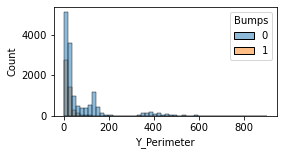

Sum_of_Luminosity


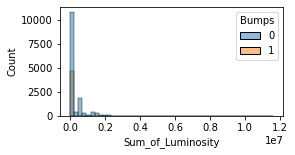

Minimum_of_Luminosity


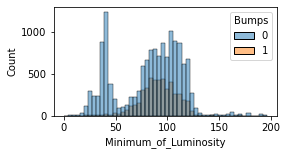

Maximum_of_Luminosity


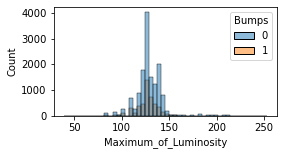

Length_of_Conveyer


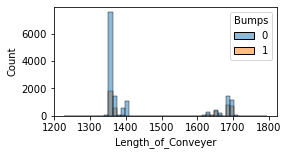

TypeOfSteel_A300


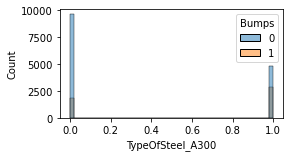

TypeOfSteel_A400


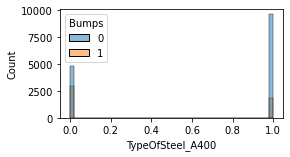

Steel_Plate_Thickness


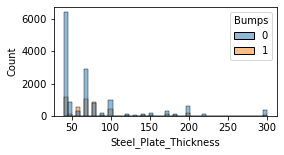

Edges_Index


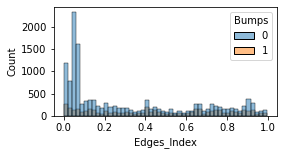

Empty_Index


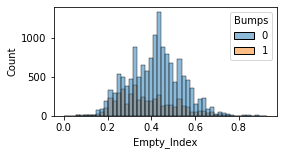

Square_Index


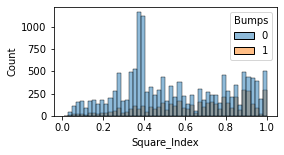

Outside_X_Index


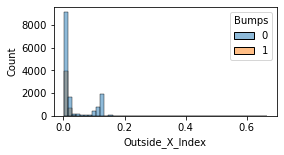

Edges_X_Index


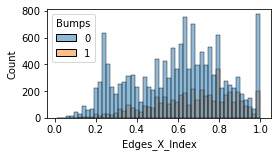

Edges_Y_Index


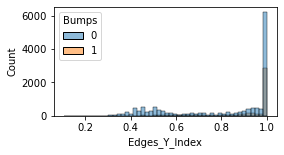

Outside_Global_Index


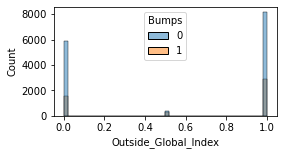

LogOfAreas


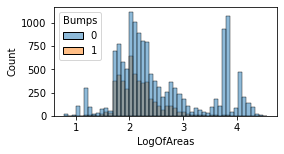

Log_X_Index


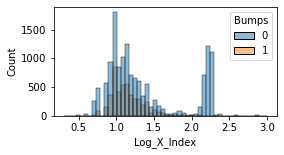

Log_Y_Index


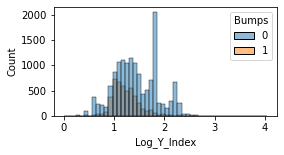

Orientation_Index


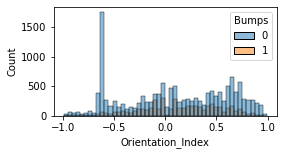

Luminosity_Index


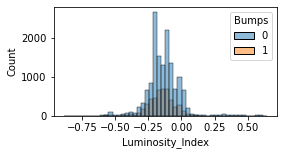

SigmoidOfAreas


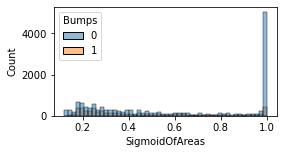

In [13]:
for column in features:
    print(column)
    fig, ax = plt.subplots(figsize=(4,2))
    fig = sns.histplot(data=train, x=column,  hue="Bumps", bins=50)
    plt.show()

#### Clean the data
- the data has NO null values - we won't need to drop any rows
- it is also 20k lines long, so we will set aside the first 1000 rows 
    for visualizations and stuff, to not crash vscode

In [5]:
classes = list(train.columns[-7:])
features = list(train.columns)[:-7]

tempdf = train.head(1000)

classes
features

['id',
 'X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'TypeOfSteel_A400',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas']

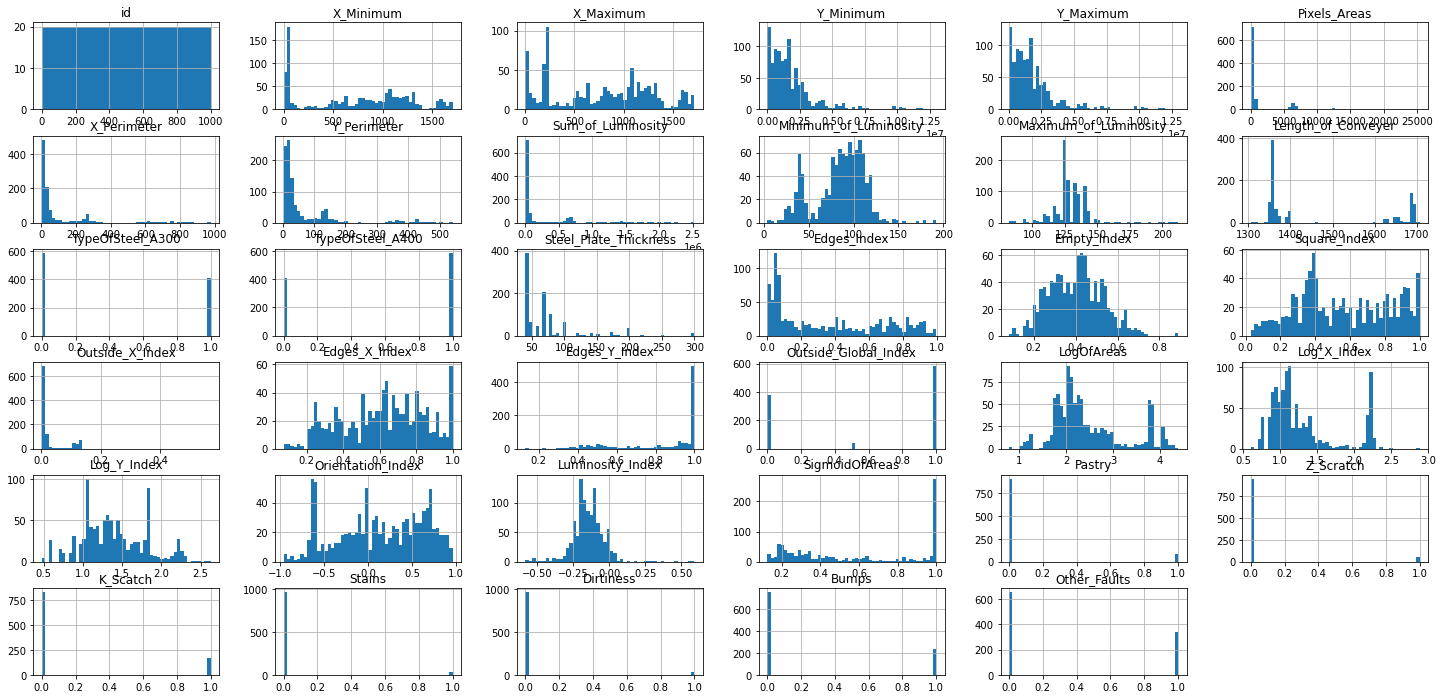

In [ ]:
#train.isnull().sum()

#sns.pairplot(tempdf,vars = features ,hue = "Other_Faults",height = 1)

#plt.show()
plt.rcParams["figure.figsize"] = (25,12)

tempdf.hist(bins=50)

plt.show()

In [ ]:
def find_count(input_feature, input_val, output_feature, df):
    sum = 0
    temp = df.loc[df[input_feature] == input_val]
    return temp[output_feature]

def get_gini(survived,total):
    survival_prob = survived/total
    die_prob = 1 - survival_prob
    random_survived_prob = survival_prob
    random_die_prob = 1 - random_survived_prob
    mislabel_survived_prob = die_prob * random_survived_prob
    mislabel_die_prob = survival_prob * random_die_prob
    gini_impurity = mislabel_die_prob + mislabel_survived_prob
    return gini_impurity

def find_split_gini(feature_name, feature_value, target_value, df):
    #calculate gini for specified feature
    temp = find_count(feature_name, feature_value, target_value, df)
    #the survived results is a pandas series with two entries, survived count and dead count, which we grab with the next lines
    feature_survived = temp.value_counts()[0] #number survived
    feature_dead = temp.value_counts()[1] #number dead
    feature_total = feature_survived + feature_dead
    feature_gini = get_gini(feature_survived, feature_total)

    #calculate gini for all other features
    othervals = df[feature_name].unique()
    val_survived = 0
    val_dead = 0
    for val in othervals: #add all the survived/dead from other labels into one pair of survived/dead, calculate its gini impurity
        if val != feature_value:
            val_temp = find_count(feature_name, val, target_value, df)
            val_survived += val_temp.value_counts()[0] #number survived
            val_dead += val_temp.value_counts()[1] #number dead
    val_total = val_dead + val_survived
    val_gini = get_gini(val_survived, val_total)

    #do the weighting
    total_people = feature_total + val_total
    feature_weight = feature_total / total_people
    #print(feature_weight)
    val_weight = val_total / total_people
    #print(val_weight)
    weighted_gini = (feature_gini * feature_weight) + (val_gini * val_weight)
    #print(feature_gini, val_gini)
    return weighted_gini

            

#finds the best features in df to minimize gini impurity. to_skip are columns we've already considered - we skip
def find_best_features(df, to_skip):
    possible_features = [] #holds tuples with feature:value pairs
    impurities = []
    for col in df.columns:
        #skip the target label - in titanic, should be survived - illogical and causes errors
        if col in to_skip: 
            continue
        
        features = df[col].unique()
        #print("-------\n", col, "\n", features)
        #case where we have a binary choice - just pick the first one
        if len(features) == 2:
            possible_features.append((col, features[0]))
        #case where we have a lot of features - add them all
        elif len(features) > 2:
            for f in features:
                possible_features.append((col, f))
    #construct a list of tuples like (feature, value, gini impurity)
    #RIGHT NOW WE ARE JUST DISCARDING ANY FEATURES THAT THROW ERRORS
    for feature in possible_features:
        try:
            impurities.append((feature[0], feature[1], find_split_gini(feature[0], feature[1], df)))
        except:
            pass
            #print("error thrown by: \n", feature[0], "\n", feature[1])
    #sorts the tuples by their last element
    impurities = sorted(impurities, key = lambda x: x[2]) 
    tuplist= []
    length = len(impurities)
    i = 0
    #removes all duplicate features, keeping the first occurence only
    # since the list is sorted, this means keeping the ones with best gini impurity
    while i < length:
        if impurities[i][0] not in tuplist:
            tuplist.append(impurities[i][0])
            i += 1
        else:
            del impurities[i]
            length -= 1
    return impurities


In [ ]:
# features
# dirtylist = []
# for f in features:
#     dirtylist.append(find_split_gini(f,1,'Dirtiness', tempdf))

# #plt.hist(dirtylist, density=True, bins=dirtylist.length) 


KeyError: 1